# Basic visualisation of preprocessed data sets

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import math

In [18]:
import brsflufight_nerc2  as bff2

## Load data

Well that's easy ;-)

In [68]:
data_sets, data_columns = bff2.load_data_files()

bff2.summarise_data(data_sets, data_columns)

historical_GHG_Sectors_GCP
--------------------------------------
Index(['Bunkers (CO2)', 'Cement (CO2)', 'Coal (CO2)', 'Gas (CO2)',
       'Gas flaring (CO2)', 'Oil (CO2)',
       'Total fossil fuels and cement (CO2)'],
      dtype='object')
--------------------------------------
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 11502 entries, ('Afghanistan', Timestamp('1960-01-01 00:00:00')) to ('Zimbabwe', Timestamp('2018-01-01 00:00:00'))
Data columns (total 11 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   Country                              11502 non-null  object        
 1   date                                 11502 non-null  datetime64[ns]
 2   Data source                          11502 non-null  object        
 3   Unit                                 11502 non-null  object        
 4   Bunkers (CO2)                        59 non-null     float64       
 5   Ceme

In [24]:
[c for c in data_sets]


['historical_GHG_Sectors_GCP',
 'historical_GHG_Sectors_PIK',
 'historical_GHG_Sectors_UNFCCC',
 'mobility_apple',
 'mobility_citymapper',
 'mobility_google',
 'uk_energy_daily']

In [47]:
data_sets['historical_GHG_Sectors_GCP'].index.duplicated().any()

True

## Visualising mobility

In [5]:
def plot_mobility(data_source, data_zone, data_sets, data_columns):
    df = data_sets[data_source]
    cols = data_columns[data_source]

    fig, axs = plt.subplots(1,2)
    fig.set_size_inches(14,5)
    fig.suptitle(f"{data_source} in {data_zone}")

    # same plot as above
    axs[0].set_title('Raw mobility data')
    df.loc[data_zone].plot(y=cols, ax=axs[0])
    # 7 Day rolling average
    axs[1].set_title('Weekly averaged mobility data')
    df.loc[data_zone, cols].rolling('7D').mean().plot(ax=axs[1])

### Google

In [6]:
# We use the helper function to identify the exact name of what we're looking for:
print(bff2.find_matching_geo_id(data_sets['mobility_google'], 'GB_United Kingdom', 'nan_'))

['GB_United Kingdom', 'GB_United Kingdom_Greater Londo', 'GB_United Kingdom_Greater Manchester', 'GB_United Kingdom_Merseyside', 'GB_United Kingdom_Na h-Eileanan an Iar', 'GB_United Kingdom_South Yorkshire', 'GB_United Kingdom_Tyne and Wear', 'GB_United Kingdom_West Midlands', 'GB_United Kingdom_West Yorkshire']


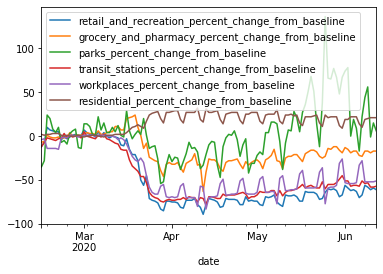

In [7]:
data_sets[
    'mobility_google'  # pick a data set
].loc[
    'GB_United Kingdom'  # use loc to pick a zone (can be done because it is a multi index)
].plot(
    y=data_columns['mobility_google']  # specify the columns to plot
)

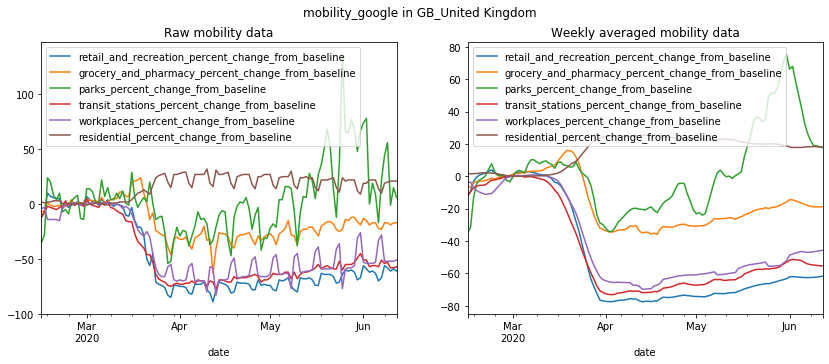

In [8]:
data_source = 'mobility_google'
data_zone = 'GB_United Kingdom'

plot_mobility(data_source, data_zone, data_sets, data_columns)

### Apple

In [9]:
print(bff2.find_matching_geo_id(data_sets['mobility_apple'], 'country/region_Unite', 'nan_'))

['country/region_United Arab Emirates', 'country/region_United Kingdom', 'country/region_United States']


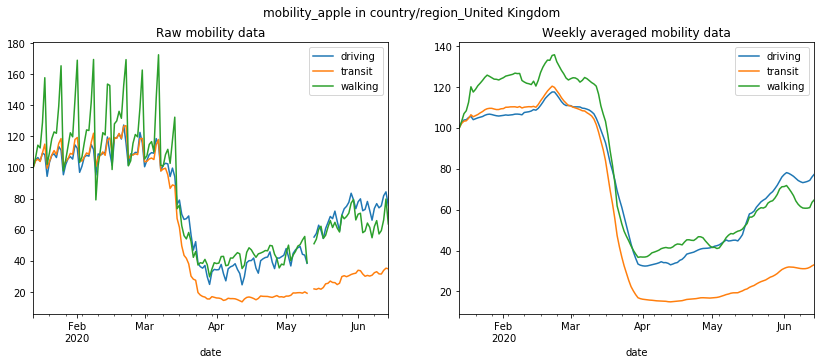

In [10]:
data_source = 'mobility_apple'
data_zone = 'country/region_United Kingdom'

plot_mobility(data_source, data_zone, data_sets, data_columns)

### Citymapper

In [11]:
citymap_mob = data_sets["mobility_citymapper"]

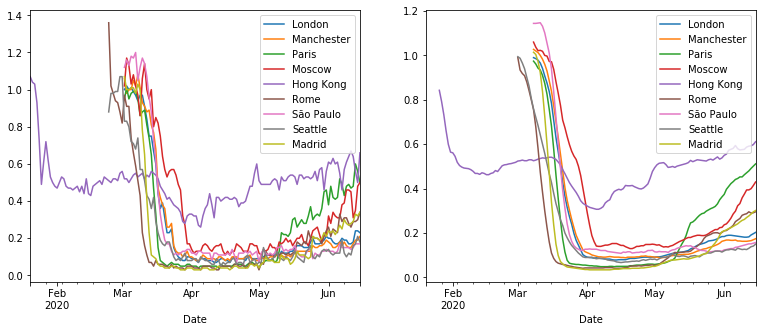

In [12]:
city_list = ['London', 'Manchester', 'Paris', 'Moscow', 'Hong Kong', 'Rome', 'São Paulo', 'Seattle', 'Madrid']

fig, axs = plt.subplots(1,2)
axs[0].figure.set_size_inches(13, 5)
citymap_mob[city_list].plot(ax=axs[0])
citymap_mob[city_list].rolling(7).mean().plot(ax=axs[1])

## Historical GHG emissions

In [101]:
def squarish_layout(n, h_max=4):
    if n <= 0:
        ValueError()
    nh = min(math.ceil(math.sqrt(n)), h_max)
    nv = math.ceil(n/nh)
    return nv,nh

def rectangular_layout(n, h_max=4):
    if n <= 0:
        ValueError()
    
    nv = math.ceil(n / h_max)
    nh = math.ceil(n / nv) 
    
    return nv,nh
    

def plot_historical_GHG_columns(
    df,
    columns,
    countries,
    gas=None,
):
    if gas is None:
        y_label_fun = "{} [{}]".format
    else:
        y_label_fun = lambda x, y :"{} [{}]".format(gas, y)

    layout = rectangular_layout(len(columns), h_max=4)
    fig, axs = plt.subplots(layout[0], layout[1])
    fig.suptitle(gas)
    fig.set_size_inches(layout[1]*5 + 2, layout[0]*5)
    axs = axs.flatten()
    for i, sector in enumerate(columns):
        for country in countries:
            idx = country
            df.loc[idx].plot(x="date", y=sector, label=f"{idx}", ax=axs[i])
        unit = df.loc[idx, "Unit"].unique()[-1]
        axs[i].set_ylabel(y_label_fun(sector, unit))
        axs[i].set_title(f"{sector}")

def plot_historical_GHG(
    data_sets, data_columns,
    data_source,
    countries,
    gases=None,
    partial_sectors=None,
    group_by=None
):
    if partial_sectors is None:
        sectors = data_columns[data_source]
    else:
        sectors = []
        for s in partial_sectors:
            sectors.extend([c for c in data_columns[data_source] if s in c])    
    if gases is not None:
        sectors_gas = []
        for gas in gases:
            sectors_gas.extend([c for c in sectors if f"({gas})" in c])
        sectors = sectors_gas

    df = data_sets[data_source]
    if group_by == 'ghg':
        for gas in gases:
            active_sectors = [s for s in sectors if f"({gas})" in s]
            plot_historical_GHG_columns(df, active_sectors, countries, gas=gas)
    elif group_by == 'sector':
        for p_sector in partial_sectors:
            active_sectors = [s for s in sectors if f"{p_sector}" in s]
            plot_historical_GHG_columns(df, active_sectors, countries)
    else:
        plot_historical_GHG_columns(df, sectors, countries)

### PIK dataset

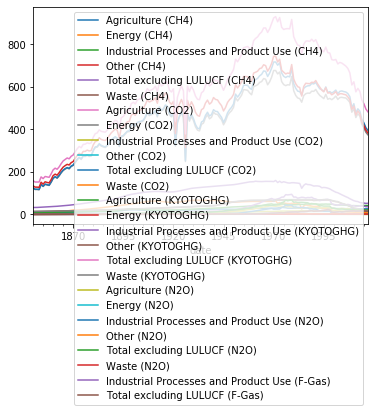

In [103]:
data_source = 'historical_GHG_Sectors_PIK'
data_sets[data_source].loc['United Kingdom'].plot(y=data_columns[data_source])

A better plotting option is available

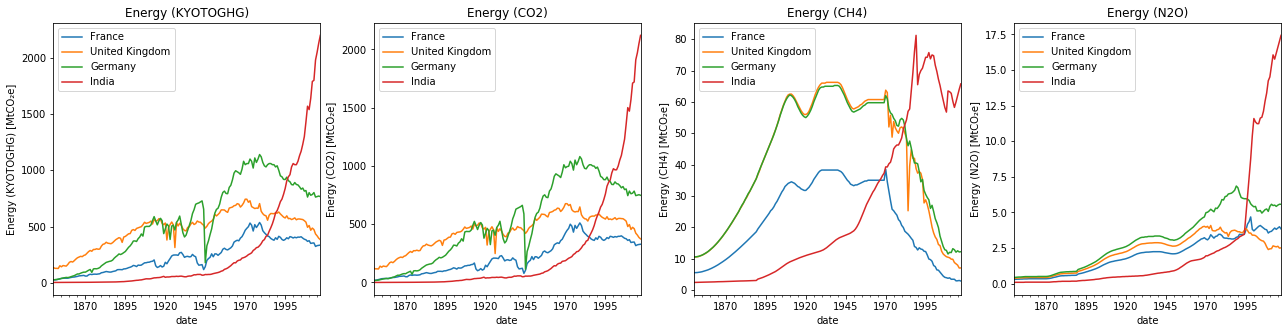

In [104]:
Sectors = [
    "Energy",
]
gases = ["KYOTOGHG", "CO2", "CH4", "N2O"]
countries = ["France", "United Kingdom", "Germany", "India"]
plot_historical_GHG(data_sets, data_columns,data_source, countries, gases, Sectors)

This can also be done for all sectors and grouping by ghg

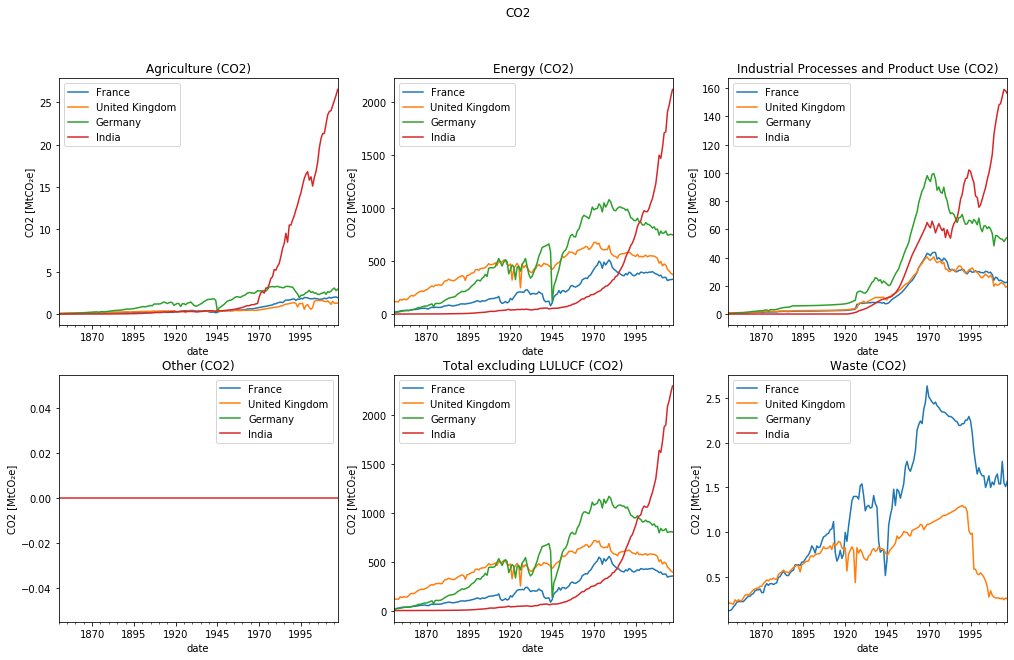

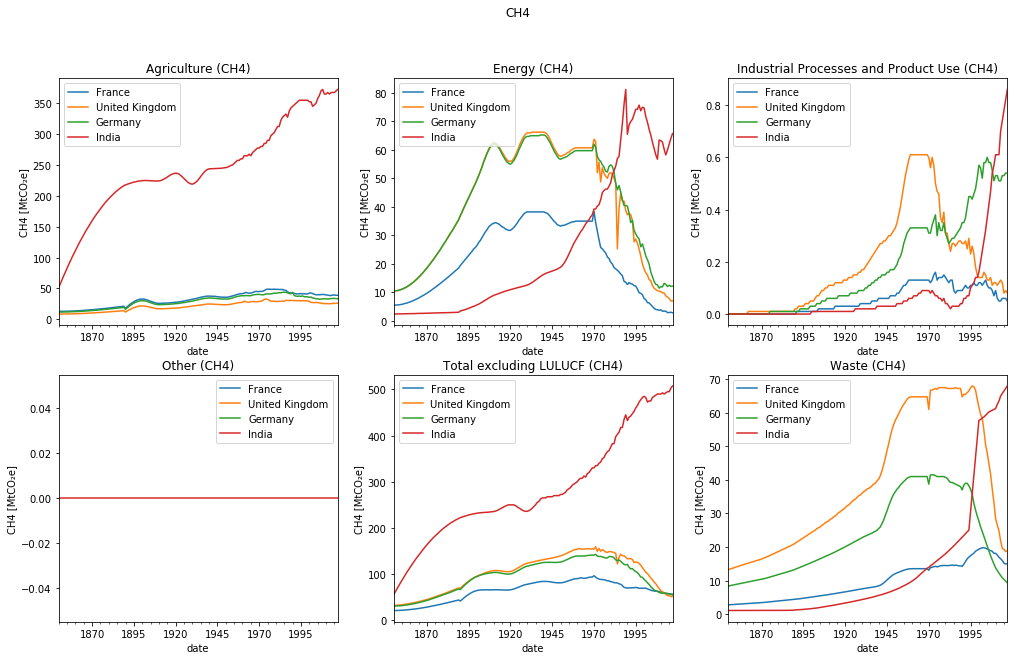

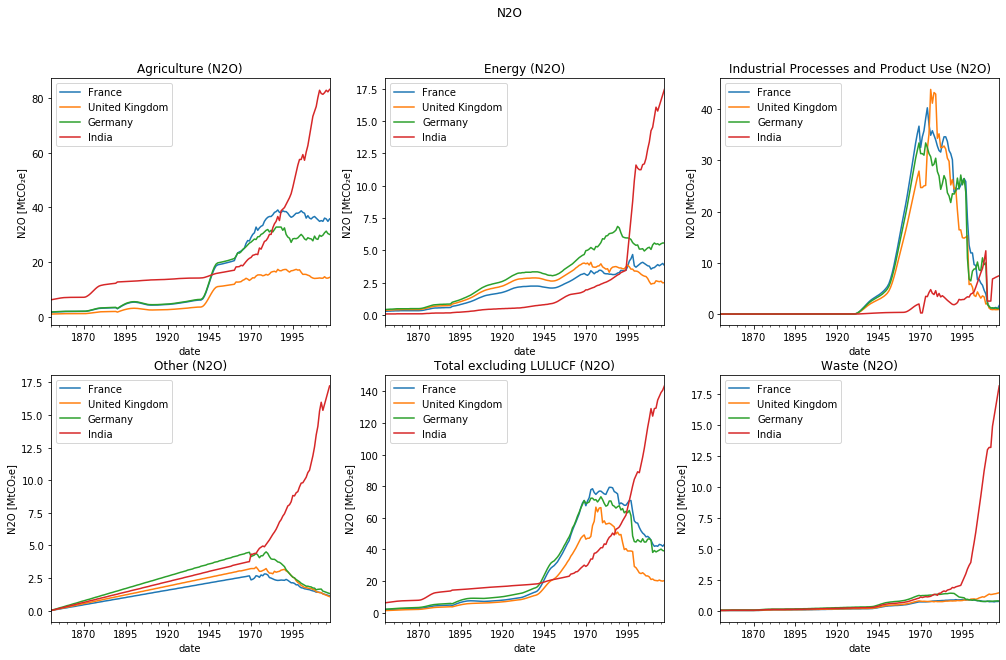

In [105]:
gases = ["CO2", "CH4", "N2O"]
plot_historical_GHG(data_sets, data_columns, data_source, countries, gases, group_by='ghg')

### Global carbon project data set

This dataset is completely different as it shows CO2 sources by fuels

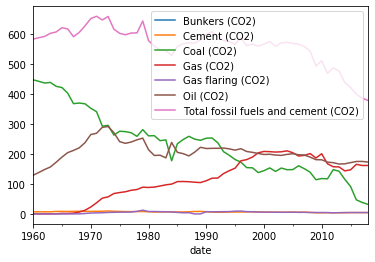

In [93]:
data_source = 'historical_GHG_Sectors_GCP'
data_sets[data_source].loc['United Kingdom'].plot(y=data_columns[data_source])

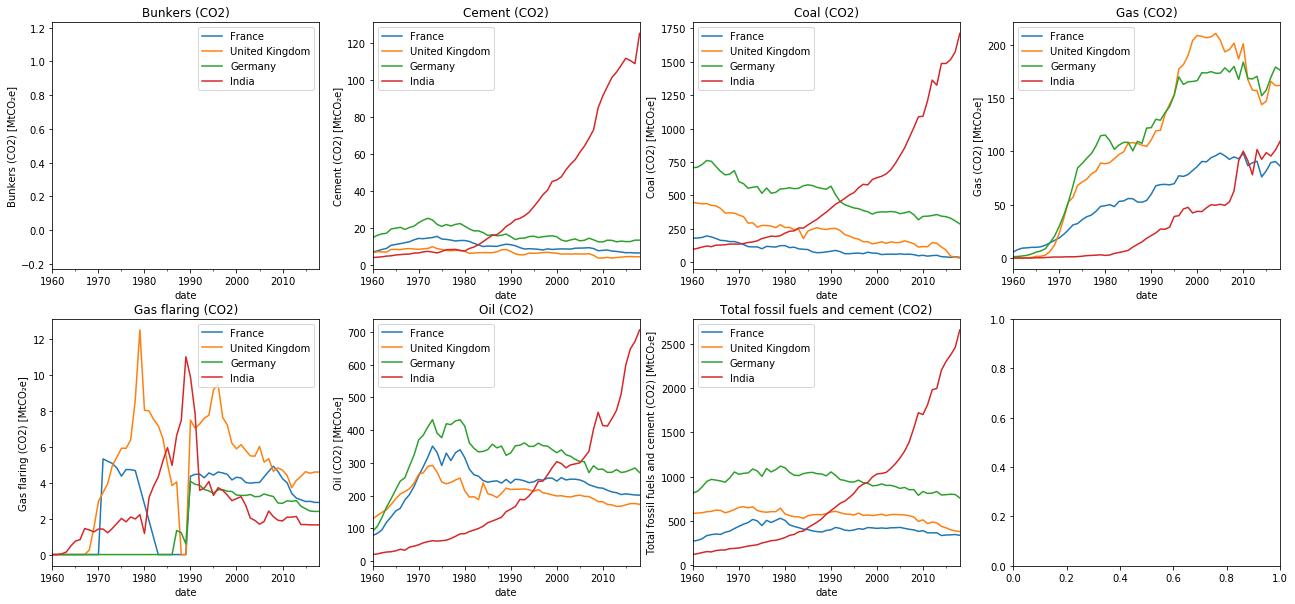

In [95]:
plot_historical_GHG(data_sets, data_columns,data_source, countries, ['CO2'])

### UNFCCC

In [96]:
data_sets[data_source]

Country       date Data source    Unit  \
Country     date                                                     
Afghanistan 1960-01-01  Afghanistan 1960-01-01         GCP  MtCO₂e   
            1961-01-01  Afghanistan 1961-01-01         GCP  MtCO₂e   
            1962-01-01  Afghanistan 1962-01-01         GCP  MtCO₂e   
            1963-01-01  Afghanistan 1963-01-01         GCP  MtCO₂e   
            1964-01-01  Afghanistan 1964-01-01         GCP  MtCO₂e   
...                             ...        ...         ...     ...   
Zimbabwe    2014-01-01     Zimbabwe 2014-01-01         GCP  MtCO₂e   
            2015-01-01     Zimbabwe 2015-01-01         GCP  MtCO₂e   
            2016-01-01     Zimbabwe 2016-01-01         GCP  MtCO₂e   
            2017-01-01     Zimbabwe 2017-01-01         GCP  MtCO₂e   
            2018-01-01     Zimbabwe 2018-01-01         GCP  MtCO₂e   

                        Bunkers (CO2)  Cement (CO2)  Coal (CO2)  Gas (CO2)  \
Country     date                                                             
Afghanistan 1960-01-01            NaN          0.02        0.13        0.0   
            1961-01-01            NaN          0.02        0.18        0.0   
            1962-01-01            NaN          0.03        0.30        0.0   
            1963-01-01            NaN          0.05        0.26        0.0   
            1964-01-01            NaN          0.06        0.30        0.0   
...                               ...           ...         ...        ...   
Zimbabwe    2014-01-01            NaN          0.50        7.73        0.0   
            2015-01-01            NaN          0.50        8.04        0.0   
            2016-01-01            NaN          0.58        7.06        0.0   
            2017-01-01            NaN          0.58        8.11        0.0   
            2018-01-01            NaN          0.58        8.25        0.0   

                        Gas flaring (CO2)  Oil (CO2)  \
Country     date                                       
Afghanistan 1960-01-01                0.0       0.27   
            1961-01-01                0.0       0.29   
            1962-01-01                0.0       0.36   
            1963-01-01                0.0       0.39   
            1964-01-01                0.0       0.48   
...                                   ...        ...   
Zimbabwe    2014-01-01                0.0       3.73   
            2015-01-01                0.0       3.62   
            2016-01-01                0.0       3.16   
            2017-01-01                0.0       3.33   
            2018-01-01                0.0       3.43   

                        Total fossil fuels and cement (CO2)  
Country     date                                             
Afghanistan 1960-01-01                                 0.41  
            1961-01-01                                 0.49  
            1962-01-01                                 0.69  
            1963-01-01                                 0.71  
            1964-01-01                                 0.84  
...                                                     ...  
Zimbabwe    2014-01-01                                11.96  
            2015-01-01                                12.16  
            2016-01-01                                10.81  
            2017-01-01                                12.03  
            2018-01-01                                12.26  

[11502 rows x 11 columns]

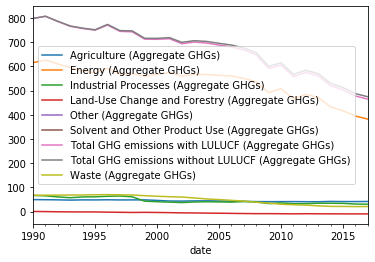

In [106]:
data_source = 'historical_GHG_Sectors_UNFCCC'
data_sets[data_source].loc['United Kingdom'].plot(y=data_columns[data_source])

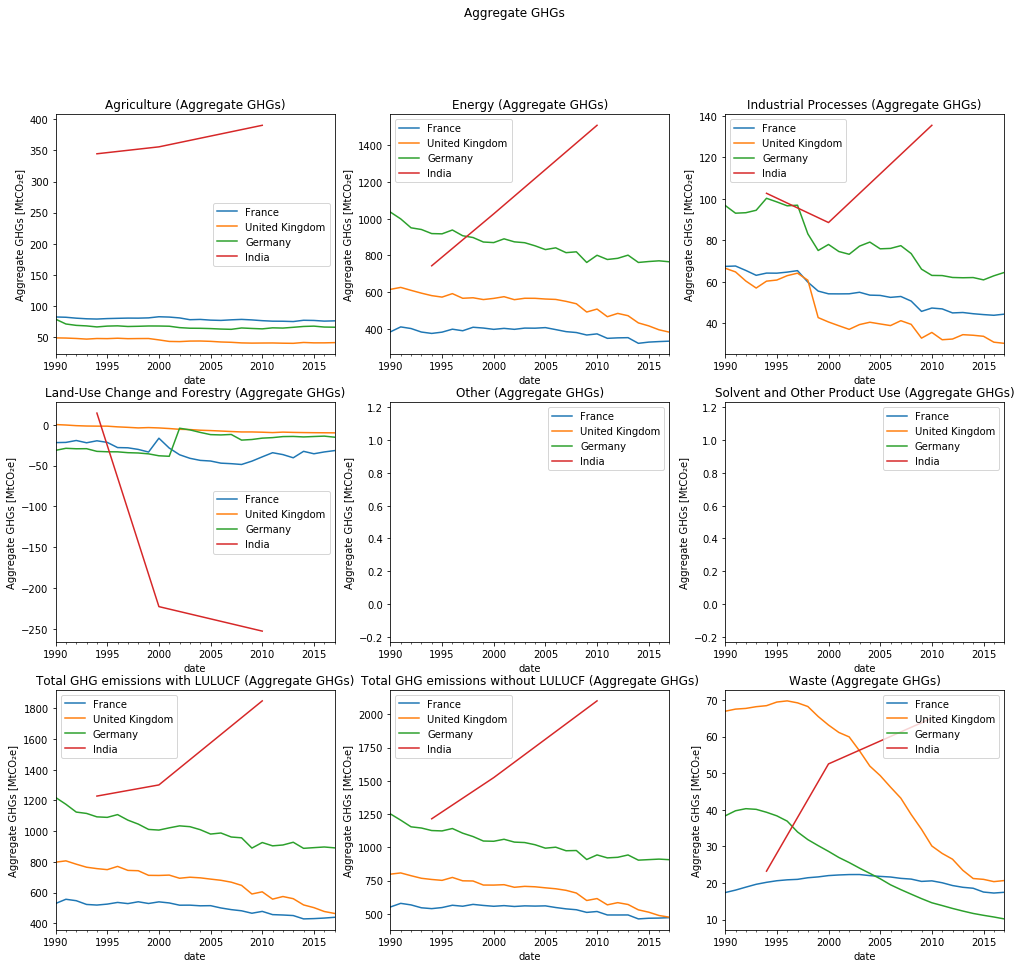

In [107]:
plot_historical_GHG(data_sets, data_columns,data_source, countries, ['Aggregate GHGs'], group_by='ghg')

## Energy data for the UK

In [30]:
data_source = 'uk_energy_daily'

Text(0, 0.5, 'Power [MW]')

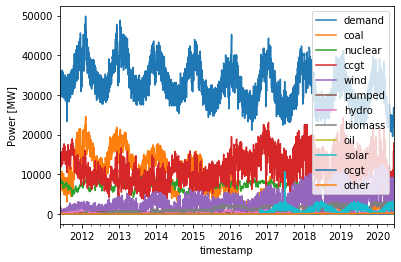

In [31]:
data_sets[data_source].plot(y=data_columns[data_source])
plt.ylabel('Power [MW]')

Text(0, 0.5, 'Power [MW]')

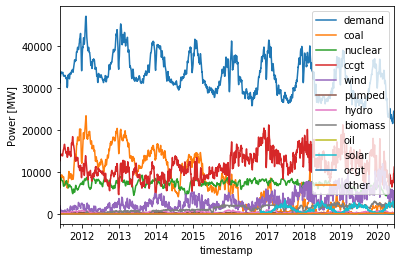

In [33]:
data_sets[data_source].rolling('7D').mean().plot(y=data_columns[data_source])
plt.ylabel('Power [MW]')

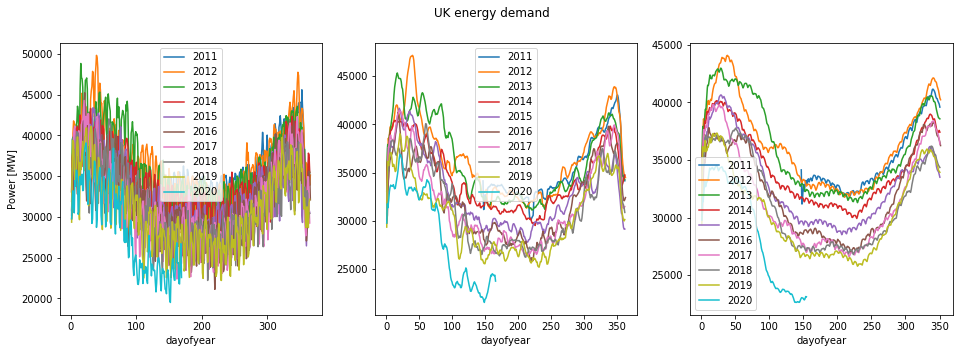

In [47]:
fig, axs = plt.subplots(1, 3)
fig.set_size_inches(16,5)
fig.suptitle("UK energy demand")
axs[0].set_ylabel('Power [MW]')
data_sets[data_source]["dayofyear"] = data_sets[data_source].index.dayofyear
for year in data_sets[data_source].index.year.unique():
    year = str(year)
    data_sets[data_source][year].rolling('1D').mean().plot(
        x="dayofyear", y="demand", ax=axs[0], label=year)
    data_sets[data_source][year].rolling('7D').mean().plot(
        x="dayofyear", y="demand", ax=axs[1], label=year)
    data_sets[data_source][year].rolling('30D').mean().plot(
        x="dayofyear", y="demand", ax=axs[2], label=year)